# Experiment 2: Do V20 lake fields + some extra surface fields improve our predicitions?

We compare two models:

* `V15`: A model using time variable features + `'cl_v15','lsm_v15','dl_v15','cvl_v15','cvh_v15','anor_v15','isor_v15','slor_v15','sr_v15','lsrh_v15'`
* `V20`: A model using time variable features, the above `*_v15` fields + corresponding V20 corrections for all the 

The correction is obtained by calculating e.g. `cl_V20 - cl_V15`.

To see how these fields change when going from V15 to V20, check out the `A1.V20_vs_V15.ipynb` notebook in this directory.

---



# 1. Plot model performance and difference

We have a V15 model which has some error relative to the true, observed data.

Ditto a V20 model.

Lets plot the error maps for each of these models, and also plot the difference in the error maps.

In [7]:
import pandas as pd
import json
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import matplotlib.colors as mc
import matplotlib.colorbar as cb 


def load_predictions(path):

    df = pd.read_pickle(path+'predictions.pkl')
    df['model_error'] = df.MODIS_LST - df.predictions
    df['absolute_model_error'] = abs(df.MODIS_LST - df.predictions)

    
    return df

def plot_training_history(path,logscale,jump_n_epochs,upper_limit,lower_limit):
    
    print('Path =', path)
    
    with open(path+'meta.txt') as f:
        lines = f.readlines()
        print(*lines)
        #print( [row for row in lines])
    
    
    
    
    with open(path+'history.json') as f:
        d = json.load(f)
        i = jump_n_epochs
        training_loss = d['loss'][i:]
        epochs = np.arange(len(training_loss))
        
        
        idxmin = np.argmin(training_loss)
        

        fig = plt.figure(figsize=(10, 10))
        plt.plot(epochs,training_loss,label='training loss')
        plt.scatter(epochs[idxmin],training_loss[idxmin])

        try:
            validation_loss = d['val_loss'][i:]
            idxmin = np.argmin(validation_loss)
            plt.plot(epochs,validation_loss, label='validation loss')
            plt.scatter(epochs[idxmin],validation_loss[idxmin])
            print('Minimum validation loss:',validation_loss[idxmin])

        except:
            pass
        plt.legend()
        
        if logscale:
            plt.yscale('log')
            
            
        plt.ylim(lower_limit,upper_limit)
        print('----------------------------------------------')


def plot_map(ds,z,vmin,vmax,cmap,logscale,title,limits,markersize):
    
    """Scatter plot. Bit hacky. """

    try:
        x = ds.longitude
        y = ds.latitude
    except: #different sources call lat/lon different things
        x = ds.longitude_ERA
        y = ds.latitude_ERA
    
    z1 = ds[z]
    

    
    #Setup figure and axes
    fig = plt.figure(figsize=[30,20])
    gs = GridSpec(1, 2, figure=fig, width_ratios=[50,1])
    ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=0))
    cax = fig.add_subplot(gs[1])
    
    #Cmaps, normalisations
    if logscale:
        norm = mc.LogNorm(vmin=vmin, vmax=vmax)
        z1 = abs(z1)
    else:
        norm = mc.Normalize(vmin=vmin, vmax=vmax)

    
    cb1 = cb.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
    
    
    
    #Plot it
    sc=ax.scatter(x,y,s=markersize,c=cmap(norm(z1)),
                linewidths=1, alpha=.7)

    
    #Tidy up
    ax.axhline(70, c='0.5', linestyle='--')
    ax.axhline(-70, c='0.5', linestyle='--') #latitude cutoffs

    ax.set_title(title)    
    ax.coastlines()

    
    ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    ax.set_aspect('auto') #Force projection aspect ratio
    
    if limits is not None:
        ax.set_xlim(limits['xlow'],limits['xhigh'])
        ax.set_ylim(limits['ylow'],limits['yhigh'])
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()
    
    
    
import seaborn as sns
def plot_distribution(df,x,bins,xlabel):
    



    #Setup plot env
    h,w = 20,20
    sns.set_theme(context='talk', 
                  style='ticks', 
                  palette='deep',
                  rc={'figure.figsize':(h,w)}
                  )
    #Figure
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(h,w))
    sns.histplot(df[x], bins=bins, ax=ax1,stat='probability',kde=False,alpha=0.7,color='C0')

    # Config
    ax1.set_xlabel(xlabel, fontsize = 20)

    ax1.axvline(0,c='0.5', linestyle='--')
    plt.show()


ModuleNotFoundError: No module named 'cartopy'

In [6]:

#Define the models to compare
models_root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/processed_data/trained_models/'
#modelV15 = models_root+'ML_5f6e838711334702b2fe6d9429c1a6ae/'#v15, batchsize 1024, LR 3e-4

modelV15 = models_root+'ML_963fe7a995c546b389402f21ef5eadd7/'#As above, with sea ice
modelV20 = models_root+'ML_1bac10ad60514426934b4709e78ddfb7/' #v20. batchsize 1024, LR 3e-4. 2 hidden layers

#new bois
modelV15 = models_root+'ML_5454e45e659043d6b295aac93aede77e/'
modelV20 = models_root+'ML_bb1359c84c8845e5ac22185fc3686b96/'

#modelV20 = models_root+'ML_792ce8ee7476412face8f0c36da82287/' #v20, batchsize 1024, LR 3e-4. OLD
# ML_d360eb7b7d0a4a45ad6eb421f1994552. v15, batchsize 10,000, LR 3e-4
#ML_6102888f3be74a08ba1324385b763f16 v20, batchsize 10,000, LR 3e-4

#Plotting parameters
cmap = plt.cm.inferno
logscale = True #None
vmin = 1
vmax = 10


#Process V15
V15 = load_predictions(modelV15) #Load data
V15_grouped = V15.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean() #averagee predictions over the year

#Process V20
V20 = load_predictions(modelV20)
V20_grouped = V20.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean()
    

#Plot training history, just for interest
plot_training_history(modelV15,logscale=False,jump_n_epochs=1,upper_limit = 25,lower_limit=17) 
plot_training_history(modelV20,logscale=False,jump_n_epochs=1,upper_limit = 25,lower_limit=17)
    
    
#Plot the map of the prediction error    
plot_map(V15_grouped,'absolute_model_error',vmin=vmin,vmax=vmax,cmap=cmap,logscale=logscale,title='|Prediction error|, V15',limits=None,markersize=1)
plot_map(V20_grouped,'absolute_model_error',vmin=vmin,vmax=vmax,cmap=cmap,logscale=logscale,title='|Prediction error|, V20',limits=None,markersize=1)

    
#Create a new df that will just hold the differences, and plot it    
data = {'latitude_ERA':   V20_grouped.latitude_ERA, 
        'longitude_ERA':  V20_grouped.longitude_ERA,
        'MODIS_LST':      V20_grouped.MODIS_LST,
        'V15_prediction': V15_grouped.predictions,
        'V20_prediction': V20_grouped.predictions,
        'V15_error':      V15_grouped.absolute_model_error,
        'V20_error':      V20_grouped.absolute_model_error,
        'delta':          V20_grouped.absolute_model_error - V15_grouped.absolute_model_error}
error_delta_field = pd.DataFrame(data)    
plot_map(error_delta_field,'delta',vmin=-2,vmax=+2,cmap=plt.cm.bwr,logscale=False,title='V20 - V15',limits=None,markersize=1)

NameError: name 'load_predictions' is not defined

---

# 2. Apply a mask


From this difference error map `V20-V15` it is hard to disentangle regions which have changed due to the improvement of the model, versus regions which have changed simply due to the inherent variability + stochasticity during training the model.

What we can do is **apply a mask to isolate just those regions where cl has been changed appreciably**. 



In [4]:
# First get the cl delta field. Go to `A1.V20_vs_V15.ipynb` to see this plotted
root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/'
version = ['v015', 'v020']
    
ds = [] #Array to hold results
for v in version:
    path = root+f'climate.{v}/climate.{v}/639l_2/clake'
    ds_i= xr.open_dataset(path,engine='cfgrib',backend_kwargs={'indexpath': ''},filter_by_keys={'shortName': 'cl'}) #only want cl 
    ds.append(ds_i)
        
#Take the difference, and make it a nice pandas df    
clake_delta_field = ds[1] - ds[0] #V20 - V15
clake_delta_field =  clake_delta_field.assign_coords({"longitude": (((clake_delta_field.longitude + 180) % 360) - 180)}) #long3 ---> long1
clake_delta_field = clake_delta_field.to_dataframe().reset_index()


NameError: name 'xr' is not defined

In [1]:
clake_delta_field

NameError: name 'clake_delta_field' is not defined

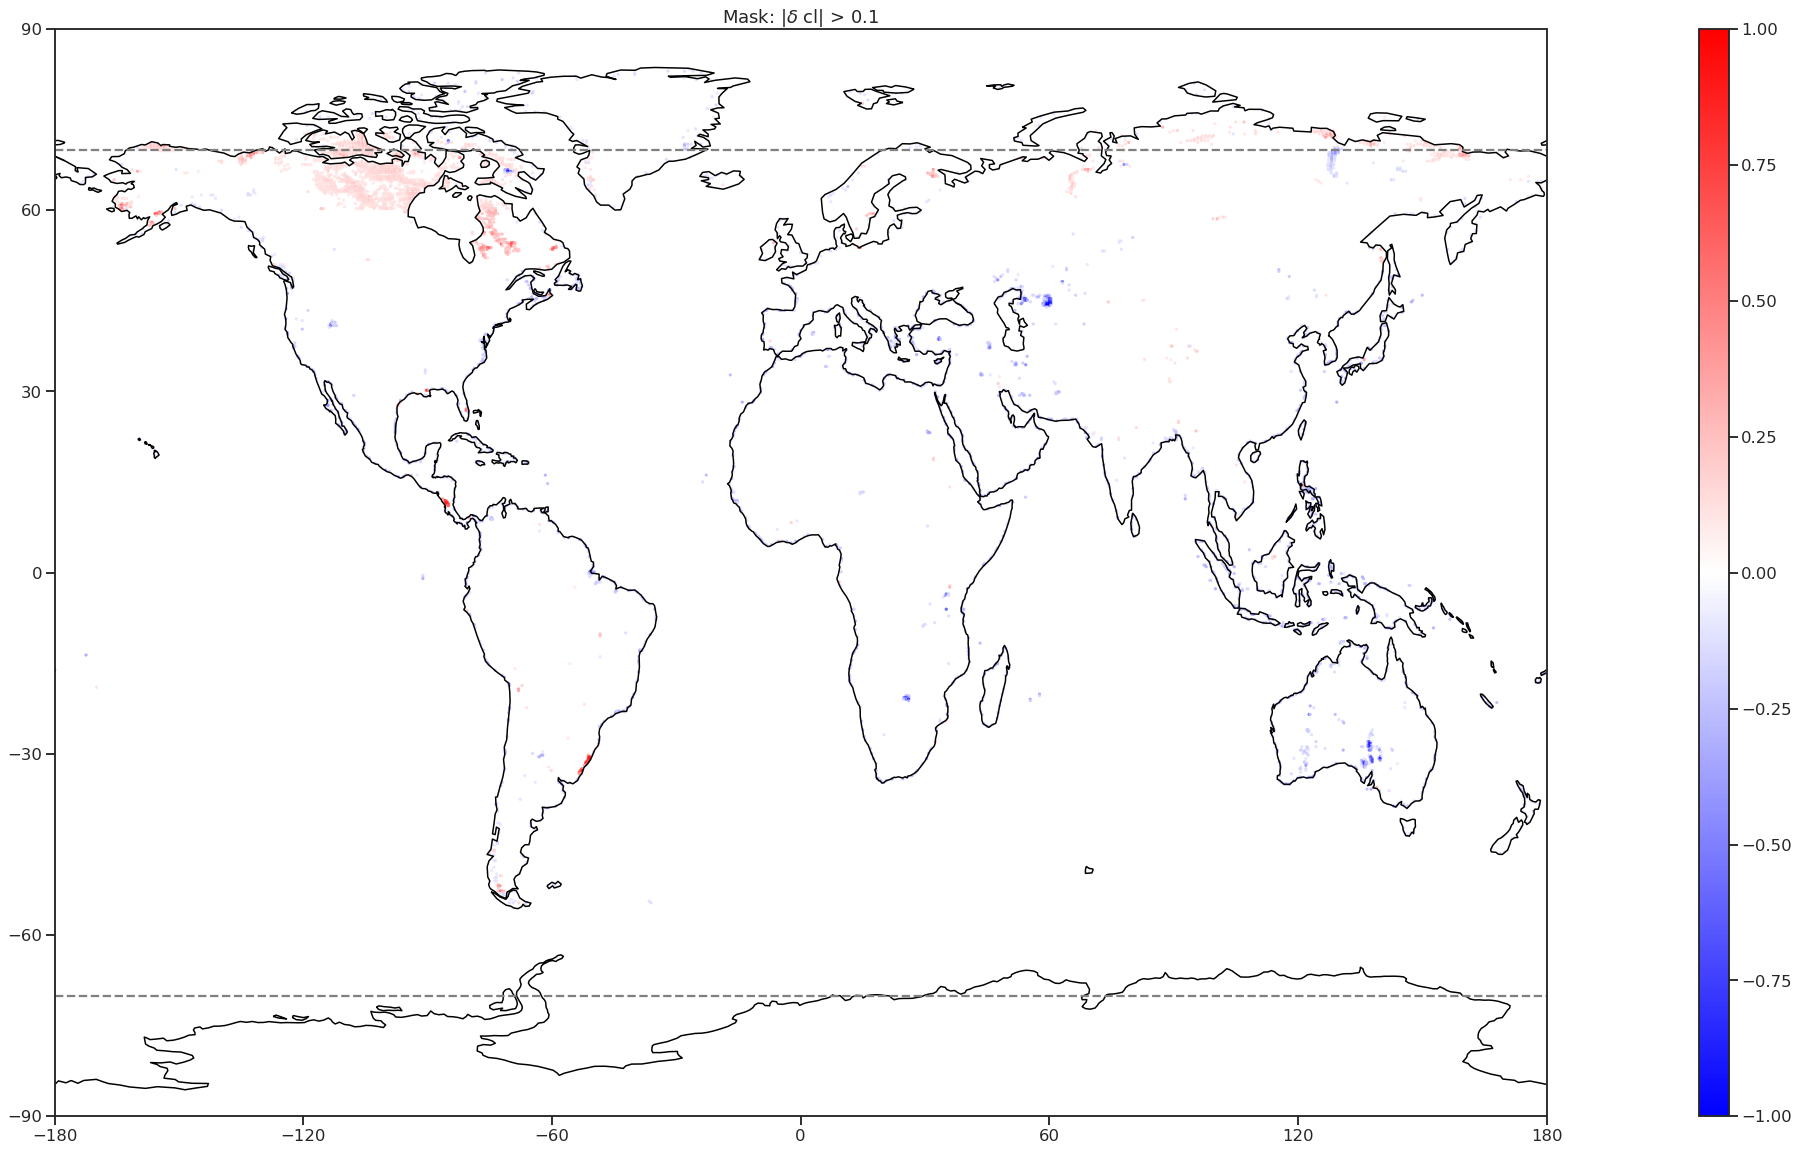

In [32]:
#Use cl delta field to create a mask 
p = 0.1 # cutoff paramter. Only get points with change in lake cover > p
mask = clake_delta_field.query(f'abs(cl) > {p}')

#Plot the mask
plot_map(mask,'cl',vmin=-1,vmax=1,cmap=plt.cm.bwr,logscale=False,title=f'Mask: |${{\delta}}$ cl| > {p}',limits=None,markersize=5) #What does this mask look like?

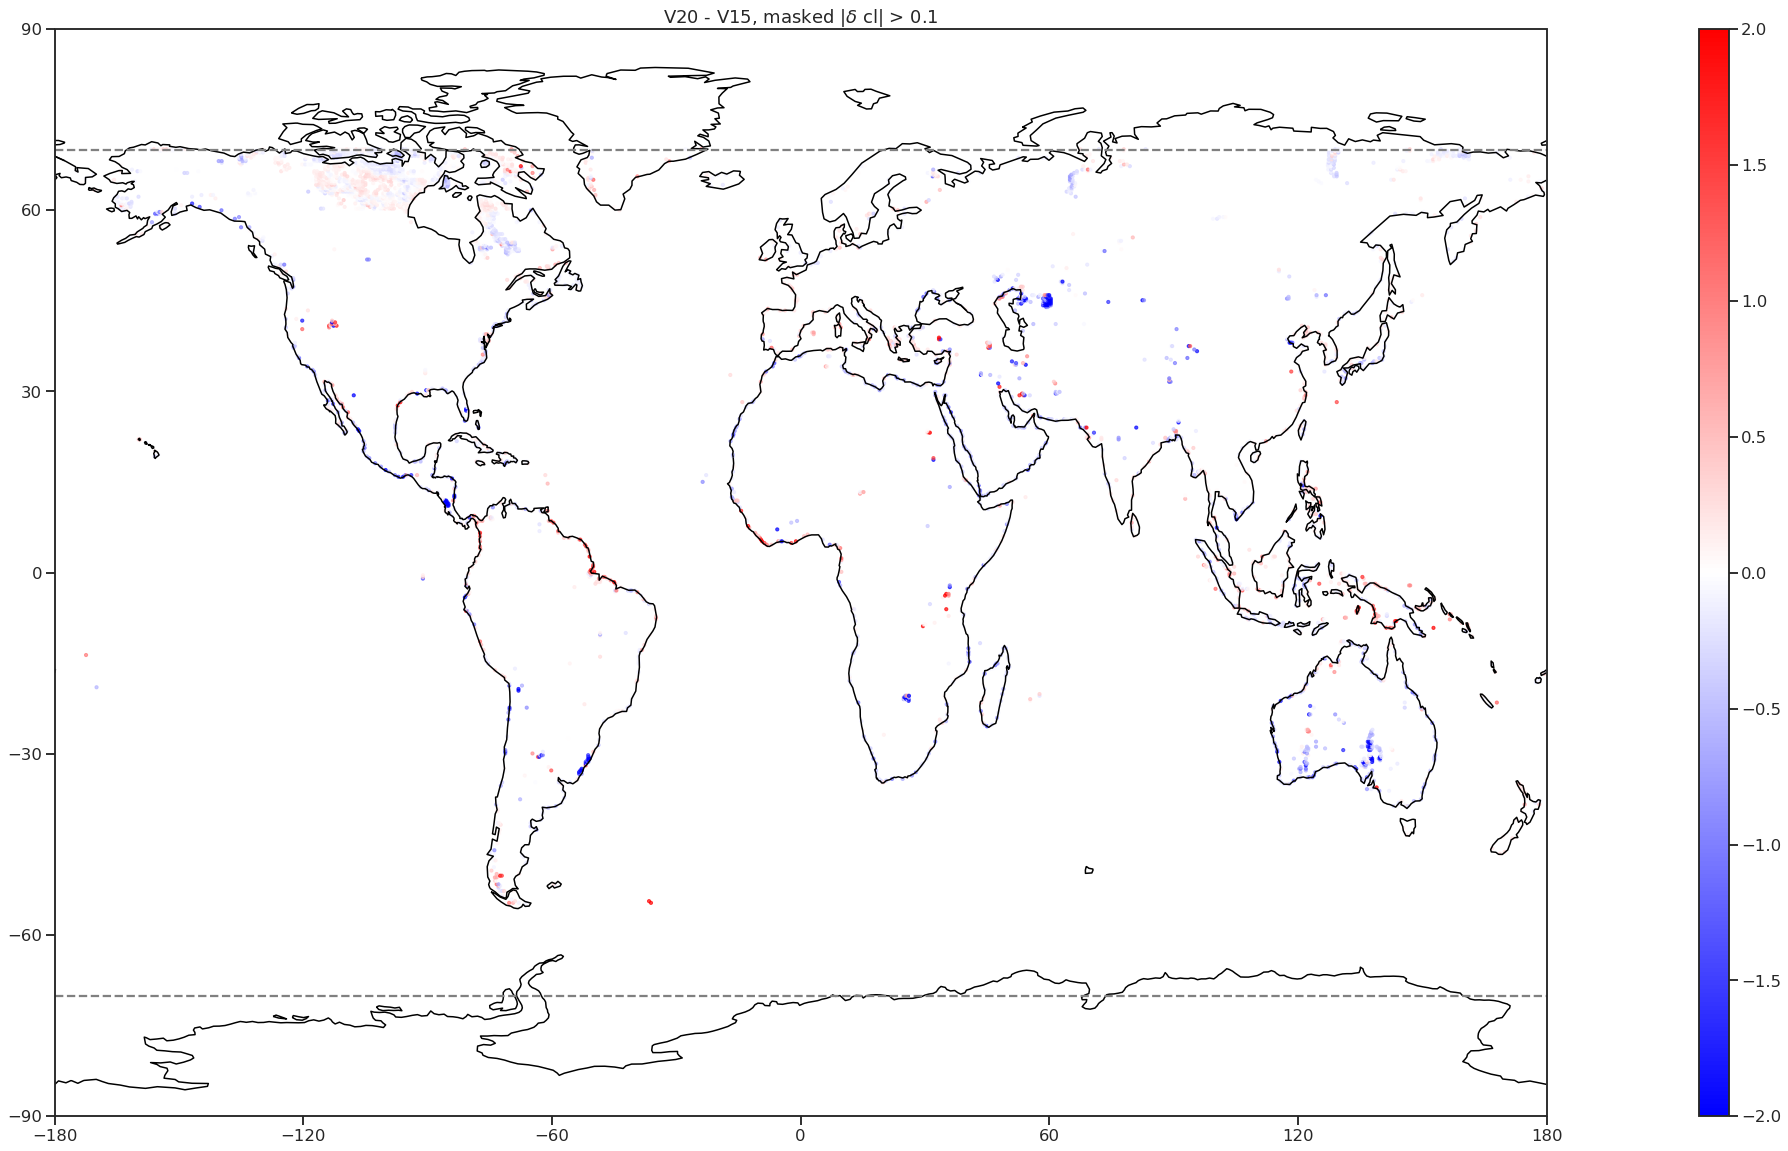

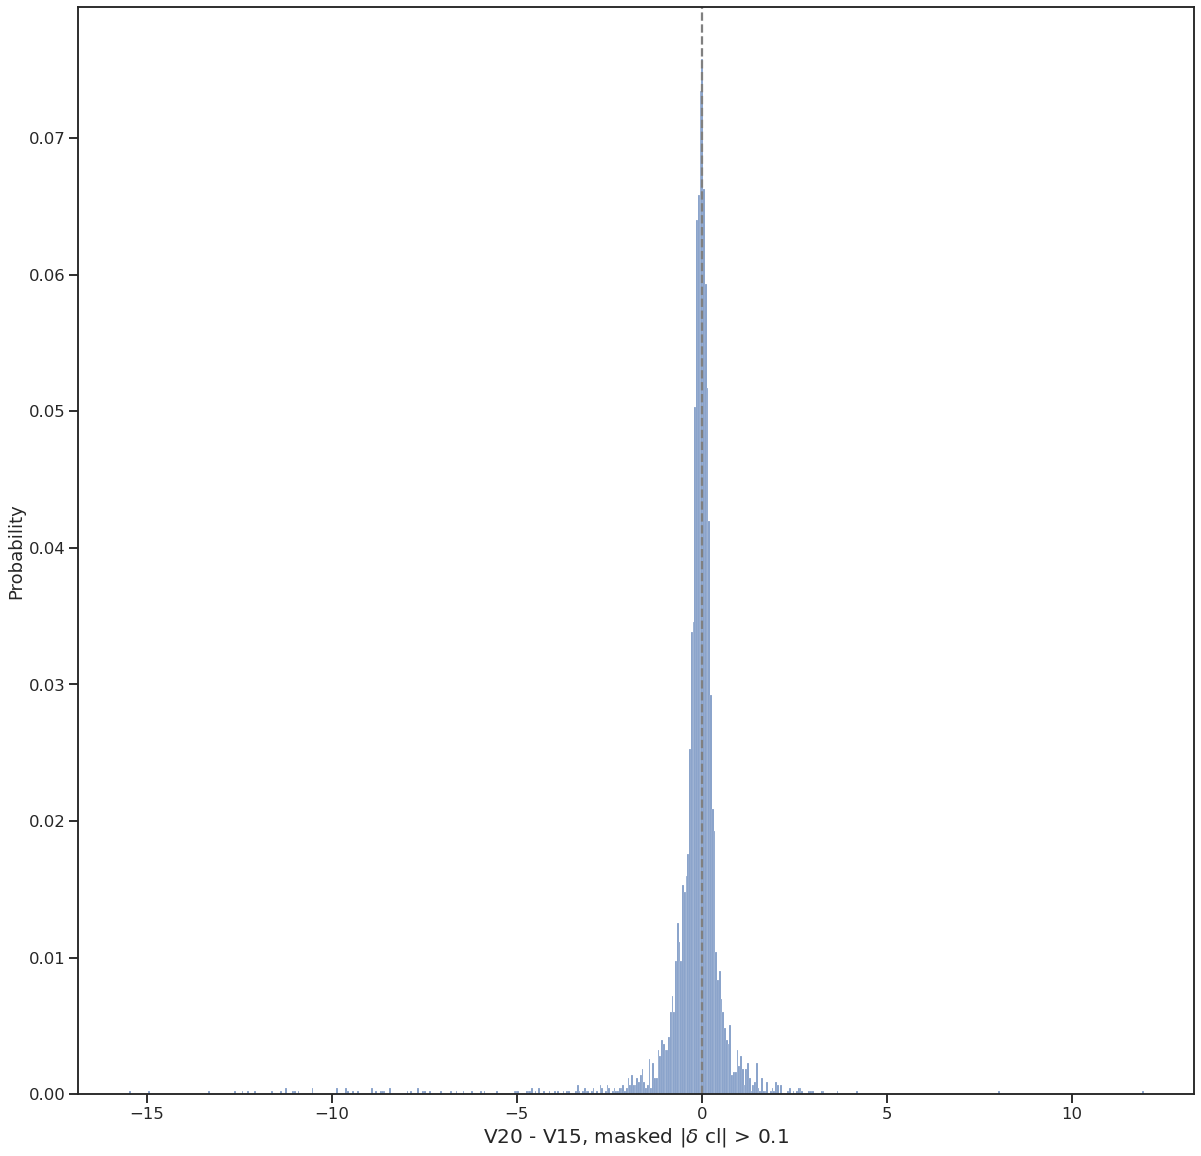

Mean change in model error = -0.18373166
Number of samples with |p| > 0.1 is: 4314
Greatest improvement:


,latitude_ERA,longitude_ERA,MODIS_LST,V15_prediction,V20_prediction,V15_error,V20_error,delta,values,step,surface,latitude,longitude,cl
344,-28.24355,137.1875,315.2164,294.41333,310.703308,20.803076,5.31992,-15.483156,397456,0 days,0.0,-28.24355,137.1875,-0.998833


Worst improvement: 


,latitude_ERA,longitude_ERA,MODIS_LST,V15_prediction,V20_prediction,V15_error,V20_error,delta,values,step,surface,latitude,longitude,cl
865,-3.512879,35.15625,301.797272,301.672577,315.649017,1.902119,13.851761,11.949641,286525,0 days,0.0,-3.512879,35.15625,-0.638541


In [35]:
#Apply the mask to the global error_delta_field from section 1
masked_error_delta_field = pd.merge(error_delta_field,mask,how='inner',left_on=['latitude_ERA', 'longitude_ERA'], right_on=['latitude', 'longitude']) #inner join.


# Plot it, along with a distribution of the errors
plot_map(masked_error_delta_field,
         'delta',
         vmin=-2,vmax=+2,
         cmap=plt.cm.bwr,
         logscale=False,
         title=f'V20 - V15, masked |${{\delta}}$ cl| > {p}',
         limits=None,
         markersize=10)
    
plot_distribution(masked_error_delta_field,
                  'delta',
                  bins='auto',
                  xlabel = f'V20 - V15, masked |${{\delta}}$ cl| > {p}')





#Surface some numbers
print('Mean change in model error =', masked_error_delta_field.delta.mean())
print (f'Number of samples with |p| > {p} is:',  len(masked_error_delta_field))
print ('Greatest improvement:')
display(masked_error_delta_field[masked_error_delta_field.delta == masked_error_delta_field.delta.min()])  #small numbers show V20 > V15
print ('Worst improvement: ') 
display(masked_error_delta_field[masked_error_delta_field.delta == masked_error_delta_field.delta.max()])  #Large numbers show V20 < V15

---

# 3. Analysis

In [26]:
display(masked_error_delta_field.sort_values(by=['delta'],ascending=False).head(20))

,latitude_ERA,longitude_ERA,MODIS_LST,V15_prediction,V20_prediction,V15_error,V20_error,delta,values,step,surface,latitude,longitude,cl
41,-3.512879,35.156250,301.797272,301.672577,315.649017,1.902119,13.851761,11.949641,286525,0 days,0.0,-3.512879,35.156250,-0.638541
40,-6.042153,35.156250,305.171234,303.088135,315.660065,2.465827,10.488852,8.023025,298045,0 days,0.0,-6.042153,35.156250,-0.727888
60,38.641672,33.398438,298.259216,294.325348,305.499268,5.204159,7.366322,2.162162,103024,0 days,0.0,38.641672,33.398438,-0.765603
106,66.463660,-70.000000,261.994904,261.829254,264.785614,4.221976,5.696397,1.474422,23527,0 days,0.0,66.463660,-70.000000,-0.725923
104,60.843060,-163.888889,272.098755,271.608826,270.350067,3.704329,4.807034,1.102704,35401,0 days,0.0,60.843060,-163.888889,0.707572
94,54.379367,-72.187500,270.896057,271.961548,267.324677,3.202963,4.283252,1.080289,52171,0 days,0.0,54.379367,-72.187500,0.731721
107,66.744690,-70.666667,261.724915,262.074615,264.211609,4.259559,5.327552,1.067993,22986,0 days,0.0,66.744690,-70.666667,-0.649780
43,0.140515,-50.906250,301.339539,302.952179,304.748199,2.490943,3.533841,1.042898,270859,0 days,0.0,0.140515,-50.906250,-0.604843
42,-0.140515,-50.625000,300.542664,303.390778,304.230164,2.930691,3.732936,0.802245,272140,0 days,0.0,-0.140515,-50.625000,-0.588097
44,0.140515,-50.625000,299.526062,302.900757,303.720215,3.425042,4.204395,0.779353,270860,0 days,0.0,0.140515,-50.625000,-0.603153


# Appendix

Old material

In [ ]:






#Get a map of the original V15 lsm. This will only be used to get rid of oceans
root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/'
lsm_path = root+f'climate.v015/climate.v015/639l_2/lsmoro'
ds_lsm= xr.open_dataset(lsm_path,engine='cfgrib',backend_kwargs={'indexpath': ''},filter_by_keys={'shortName': 'lsm'}) 
ds_lsm = correct_longitude(ds_lsm)
lsm_df = ds_lsm.to_dataframe().reset_index() #Make it a df
all_fields = lsm_df.copy()



#Now look at all the features which are changing
changing_features = ['cl','lsm','dl','cvl','cvh','anor','isor','slor','sr','lsrh']
changing_files =    ['clake','lsmoro','lakedl','sfc','sfc','sfc','sfc','sfc','sfc','sfc']


for i in range(len(changing_features)): 
    file = changing_files[i]
    feature=changing_features[i]
    delta = difference_in_surface_fields(file,feature)
    
    all_fields[f'delta_{feature}'] = delta[feature].values
    
    
    
    
print ('Plotting map of changing features')
for f in changing_features: 
    plot_map(all_fields,f'delta_{feature}',vmin=1e-2,vmax=10,cmap=plt.cm.bwr,logscale=True,title=f'Change in {feature}',limits=limits,markersize=1)
    
    
# #We can define some masks based on how we want to filter the data
# strong_mask = all_fields.query('abs(delta_cl) > 0.1 & abs(delta_lsm) > 0.0 & abs(delta_dl)>0.0 & abs(delta_cvl) > 0.0 & abs(delta_cvh) > 0.0')
# weak_mask = all_fields.query('abs(delta_cl) > 0.1')

# plot_map(all_fields,'delta_cl',vmin=-0.05,vmax=+0.01,cmap=plt.cm.bwr,logscale=False,title='Change in lake cover',limits=limits,markersize=1)
# plot_map(strong_mask,'delta_cl',vmin=1e-1,vmax=+1,cmap=plt.cm.bwr,logscale=True,title=f'Strong Mask: Change in Lake cover cl',limits=None,markersize=10) #What does this mask look like?
# plot_map(weak_mask,'delta_cl',vmin=1e-1,vmax=+1,cmap=plt.cm.bwr,logscale=True,title=f'Weak Mask, Change in Lake cover cl',limits=None,markersize=10) #What does this mask look like?





# #Now look at all the features which are changing
# changing_features = ['cl','lsm','dl','cvl','cvh','anor','isor','slor','sr','lsrh']
# changing_files =    ['clake','lsmoro','lakedl','sfc','sfc','sfc','sfc','sfc','sfc','sfc']


# for i in range(len(changing_features)): 
#     file = changing_files[i]
#     feature=changing_features[i]
#     delta = difference_in_surface_fields(file,feature)
    
#     all_fields[f'delta_{feature}'] = delta[feature].values
    
    
    
    
# print ('Plotting map of changing features')
# for f in changing_features: 
#     plot_map(all_fields,f'delta_{feature}',vmin=1e-2,vmax=10,cmap=plt.cm.bwr,logscale=True,title=f'Change in {feature}',limits=limits,markersize=1)

    

In [ ]:
# from matplotlib.gridspec import GridSpec
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import xarray as xr
# import matplotlib.colors as mc
# import matplotlib.colorbar as cb 




# def correct_longitude(ds):    
#     return ds.assign_coords({"longitude": (((ds.longitude + 180) % 360) - 180)})


# def plot_map(ds,z,vmin,vmax,cmap,logscale,title,limits,markersize):
    
#     """Scatter plot. Bit hacky. """

#     try:
#         x = ds.longitude
#         y = ds.latitude
#     except: #different sources call lat/lon different things
#         x = ds.longitude_ERA
#         y = ds.latitude_ERA
    
#     z1 = ds[z]
    

    
#     #Setup figure and axes
#     fig = plt.figure(figsize=[30,20])
#     gs = GridSpec(1, 2, figure=fig, width_ratios=[50,1])
#     ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=0))
#     cax = fig.add_subplot(gs[1])
    
#     #Cmaps, normalisations
#     if logscale:
#         norm = mc.LogNorm(vmin=vmin, vmax=vmax)
#         z1 = abs(z1)
#     else:
#         norm = mc.Normalize(vmin=vmin, vmax=vmax)

    
#     cb1 = cb.ColorbarBase(cax, cmap=cmap,
#                                 norm=norm,
#                                 orientation='vertical')
    
    
    
#     #Plot it
#     sc=ax.scatter(x,y,s=markersize,c=cmap(norm(z1)),
#                 linewidths=1, alpha=.7)

    
#     #Tidy up
#     ax.axhline(70, c='0.5', linestyle='--')
#     ax.axhline(-70, c='0.5', linestyle='--') #latitude cutoffs

#     ax.set_title(title)    
#     ax.coastlines()

    
#     ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
#     ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
#     ax.set_aspect('auto') #Force projection aspect ratio
    
#     if limits is not None:
#         ax.set_xlim(limits['xlow'],limits['xhigh'])
#         ax.set_ylim(limits['ylow'],limits['yhigh'])
#         ax.set_xticks([])
#         ax.set_yticks([])

#     plt.show()
    
    
    
    
# def difference_in_surface_fields(file,feature):
    
    
#     version = ['v015', 'v020']
    
#     ds = [] #Array to hold results
#     for v in version:
#         path = root+f'climate.{v}/climate.{v}/639l_2/{file}'
#         ds_i= xr.open_dataset(path,engine='cfgrib',backend_kwargs={'indexpath': ''},filter_by_keys={'shortName': feature}) 
#         ds.append(ds_i)
        
        
    
#     #Take the difference    
#     delta = ds[1] - ds[0] #V20 - V15
#     delta = correct_longitude(delta) #long3 ---> long1
    
#     return delta
    